<a href="https://colab.research.google.com/github/scj02/GemeloDigital/blob/Rama_Cris/Prueba_Gemelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install web3

In [29]:
import hashlib
import json
import time
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt

from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import serialization
from cryptography.exceptions import InvalidSignature
from matplotlib.patches import FancyBboxPatch

# Web3 (requiere conexión a un proveedor como Infura o Alchemy en testnet)
from web3 import Web3

In [30]:
# Gemelo Digital inicial
diploma = {
    "id": "DIP-003",
    "estudiante": "Santiago Cruz",
    "programa": "Medicina",
    "estado": "En revisión",
    "atributos": {
        "paz_y_salvo": True,
        "notas_completas": True,
        "deudas": False,
        "creditos_cumplidos": 160,
        "creditos_totales": 160,
        "certificado_idioma": True,
        "saber_pro": True,
        "pago_matricula_fallido": False,  # Tesorería
        "otros_servicios_pendientes": False,  # Tesorería
        "libros_no_devueltos": False,  # Biblioteca
        "danos_equipo_biblioteca": False,  # Biblioteca
        "danos_equipo_bienestar": False,   # Bienestar Estudiantil
        "multas_bienestar": False         # Bienestar Estudiantil
    },
    "historial": []
}

print("Gemelo Digital inicial:", json.dumps(diploma, indent=2, ensure_ascii=False))

Gemelo Digital inicial: {
  "id": "DIP-003",
  "estudiante": "Santiago Cruz",
  "programa": "Medicina",
  "estado": "En revisión",
  "atributos": {
    "paz_y_salvo": true,
    "notas_completas": true,
    "deudas": false,
    "creditos_cumplidos": 160,
    "creditos_totales": 160,
    "certificado_idioma": true,
    "saber_pro": true,
    "pago_matricula_fallido": false,
    "otros_servicios_pendientes": false,
    "libros_no_devueltos": false,
    "danos_equipo_biblioteca": false,
    "danos_equipo_bienestar": false,
    "multas_bienestar": false
  },
  "historial": []
}


In [31]:
def actualizar_estado(diploma, nuevo_estado):
    diploma["estado"] = nuevo_estado
    diploma["historial"].append({
        "estado": nuevo_estado,
        "timestamp": datetime.utcnow().isoformat() + "Z"
    })

In [32]:
# Información de Tesorería: Validación de deudas
def validar_deudas_tesoreria(diploma):
    deudas = []

    # Validar si el pago de matrícula no fue procesado correctamente
    if diploma["atributos"].get("pago_matricula_fallido", False):
        deudas.append("🚩 Pago de matrícula fallido")

    # Validar si hay algún otro tipo de deuda con la universidad
    if diploma["atributos"].get("otros_servicios_pendientes", False):
        deudas.append("🚩 Deuda por otros servicios no pagados")

    return deudas


In [33]:
# Información de Biblioteca: Validación de multas o daños
def validar_deudas_biblioteca(diploma):
    deudas = []

    # Validar si hay una multa por libros no devueltos
    if diploma["atributos"].get("libros_no_devueltos", False):
        deudas.append("🚩 Multa por libros no devueltos")

    # Validar si se ha dañado equipo de la biblioteca (por ejemplo, PCs)
    if diploma["atributos"].get("danos_equipo_biblioteca", False):
        deudas.append("🚩 Daños a equipo de la biblioteca (ej: PC, impresoras)")

    return deudas


In [34]:
# Información de Bienestar Estudiantil: Validación de daños o multas
def validar_deudas_bienestar(diploma):
    deudas = []

    # Validar si ha dañado algún equipo de bienestar estudiantil
    if diploma["atributos"].get("danos_equipo_bienestar", False):
        deudas.append("🚩 Daños a equipos de bienestar estudiantil (ej: controles, DVD)")

    # Validar si hay multas por no cumplir con normativas de bienestar
    if diploma["atributos"].get("multas_bienestar", False):
        deudas.append("🚩 Multas por no cumplir con normativas de bienestar estudiantil")

    return deudas


In [35]:
def validar_diploma(d):
    reglas = []

    # --- Reglas de validación básicas ---
    if not d["atributos"]["paz_y_salvo"]:
        reglas.append("🚩 No está paz y salvo (pendiente de biblioteca o pagos)")

    if d["atributos"]["deudas"]:
        reglas.append("🚩 Tiene deudas pendientes con la universidad")

    if not d["atributos"]["notas_completas"]:
        reglas.append("🚩 No completó todas las asignaturas del plan de estudios")

    if d["atributos"]["creditos_cumplidos"] < d["atributos"]["creditos_totales"]:
        reglas.append("🚩 No ha completado todos los créditos requeridos")

    if d["atributos"]["creditos_cumplidos"] > d["atributos"]["creditos_totales"]:
        reglas.append("🚩 Créditos exceden lo requerido (posible error o fraude)")

    if d["atributos"]["creditos_totales"] != 160:
        reglas.append("🚩 El total de créditos no coincide con el plan oficial (160)")

    # --- Validaciones de Tesorería ---
    deudas_tesoreria = validar_deudas_tesoreria(diploma)
    if deudas_tesoreria:
        reglas.extend(deudas_tesoreria)

    # --- Validaciones de Biblioteca ---
    deudas_biblioteca = validar_deudas_biblioteca(diploma)
    if deudas_biblioteca:
        reglas.extend(deudas_biblioteca)

    # --- Validaciones de Bienestar Estudiantil ---
    deudas_bienestar = validar_deudas_bienestar(diploma)
    if deudas_bienestar:
        reglas.extend(deudas_bienestar)

    if not d["atributos"].get("certificado_idioma", False):
        reglas.append("🚩 No cumple requisito de certificado de idioma")

    if not d["atributos"].get("saber_pro", False):
        reglas.append("🚩 No aprobó el examen Saber Pro")

    return reglas


# --- Ejecución de validación ---
banderas = validar_diploma(diploma)

if banderas:
    actualizar_estado(diploma, "Bloqueado - Banderas rojas")
    print("❌ Integridad comprometida. Motivos detectados:")
    for b in banderas:
        print("   ", b)
else:
    actualizar_estado(diploma, "Apto para emisión")
    print("✅ Diploma válido e íntegro")

✅ Diploma válido e íntegro


/tmp/ipython-input-4042965120.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z"


In [36]:
# Serialización determinista y hash
diploma_json = json.dumps(diploma, sort_keys=True, ensure_ascii=False).encode()
hash_diploma = hashlib.sha256(diploma_json).hexdigest()

diploma["hash"] = hash_diploma
diploma["historial"].append({
    "evento": "Hash generado",
    "hash": hash_diploma,
    "timestamp": datetime.utcnow().isoformat() + "Z"
})

print("Gemelo Digital actualizado:", json.dumps(diploma, indent=2, ensure_ascii=False))
print("Hash anclado (simulado blockchain):", hash_diploma)

Gemelo Digital actualizado: {
  "id": "DIP-003",
  "estudiante": "Santiago Cruz",
  "programa": "Medicina",
  "estado": "Apto para emisión",
  "atributos": {
    "paz_y_salvo": true,
    "notas_completas": true,
    "deudas": false,
    "creditos_cumplidos": 160,
    "creditos_totales": 160,
    "certificado_idioma": true,
    "saber_pro": true,
    "pago_matricula_fallido": false,
    "otros_servicios_pendientes": false,
    "libros_no_devueltos": false,
    "danos_equipo_biblioteca": false,
    "danos_equipo_bienestar": false,
    "multas_bienestar": false
  },
  "historial": [
    {
      "estado": "Apto para emisión",
      "timestamp": "2025-10-24T20:42:25.417585Z"
    },
    {
      "evento": "Hash generado",
      "hash": "847947f4420cb1a38b908e0a3d59f1dacb6783494f54e669f967a25a85384f93",
      "timestamp": "2025-10-24T20:42:25.426512Z"
    }
  ],
  "hash": "847947f4420cb1a38b908e0a3d59f1dacb6783494f54e669f967a25a85384f93"
}
Hash anclado (simulado blockchain): 847947f4420cb1a38b

/tmp/ipython-input-2169702725.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z"


In [37]:
# Generación de claves ECDSA (p256)
private_key = ec.generate_private_key(ec.SECP256R1())
public_key = private_key.public_key()

# Firmar hash
hash_bytes = bytes.fromhex(hash_diploma)
signature = private_key.sign(hash_bytes, ec.ECDSA(hashes.SHA256()))

# Verificar firma
try:
    public_key.verify(signature, hash_bytes, ec.ECDSA(hashes.SHA256()))
    print("✅ Firma verificada correctamente")
except InvalidSignature:
    print("❌ Firma inválida")

# Exportar clave pública PEM
pem_pub = public_key.public_bytes(
    encoding=serialization.Encoding.PEM,
    format=serialization.PublicFormat.SubjectPublicKeyInfo
)
print(pem_pub.decode())

✅ Firma verificada correctamente
-----BEGIN PUBLIC KEY-----
MFkwEwYHKoZIzj0CAQYIKoZIzj0DAQcDQgAElyZmMcOGINw1jGm1ZIYcHCP68sl0
7kbi7TL2CR/Q07VsGTfLEfXs9zp/fyph8iAst2JFncC7yvWplldOVrHFMw==
-----END PUBLIC KEY-----



In [38]:
# Conectar a Sepolia con Infura
infura_url = "https://sepolia.infura.io/v3/1e0a83b4b7ea4916ba64da9e4d1213a9"
w3 = Web3(Web3.HTTPProvider(infura_url))

print("¿Conectado?", w3.is_connected())

private_key = "0x4c0883a69102937d6231471b5dbb6204fe5129617082797a64894ccf37d85a7a"
acct = w3.eth.account.from_key(private_key)
print("Dirección:", acct.address)

# Hash del diploma
import hashlib
hash_diploma = hashlib.sha256(b"Diploma Johan Ayala 2025").hexdigest()
print("Hash del diploma:", hash_diploma)

# Construir la transacción
tx = {
    'to': acct.address,
    'value': 0,
    'data': bytes.fromhex(hash_diploma),
    'gas': 50000,
    'gasPrice': w3.to_wei('20', 'gwei'),
    'nonce': w3.eth.get_transaction_count(acct.address)
}

# Firmar y enviar
signed_tx = w3.eth.account.sign_transaction(tx, private_key)
tx_hash = w3.eth.send_raw_transaction(signed_tx.raw_transaction)

print("Transacción enviada. Hash:", tx_hash.hex())

¿Conectado? True
Dirección: 0x1C98cfeaEc61518F3f80a1aD9f93E1E42AAE62CB
Hash del diploma: 3a764b52a5debaa4ab6114a66f5726a38b9f69e432f3770c53350a73bf48b838


Web3RPCError: {'code': -32000, 'message': 'insufficient funds for gas * price + value: balance 0, tx cost 1000000000000000, overshot 1000000000000000'}

In [39]:
df = pd.DataFrame([{
    "id": diploma["id"],
    "estudiante": diploma["estudiante"],
    "programa": diploma["programa"],
    "estado": diploma["estado"],
    "hash": diploma["hash"],
    "historial": json.dumps(diploma["historial"], ensure_ascii=False)
}])
df.to_csv("diplomas.csv", index=False, encoding="utf-8")
print("Diploma guardado en diplomas.csv")

df_loaded = pd.read_csv("diplomas.csv", encoding="utf-8")
print("Diplomas cargados:")
print(df_loaded)

Diploma guardado en diplomas.csv
Diplomas cargados:
        id     estudiante  programa             estado  \
0  DIP-003  Santiago Cruz  Medicina  Apto para emisión   

                                                hash  \
0  847947f4420cb1a38b908e0a3d59f1dacb6783494f54e6...   

                                           historial  
0  [{"estado": "Apto para emisión", "timestamp": ...  


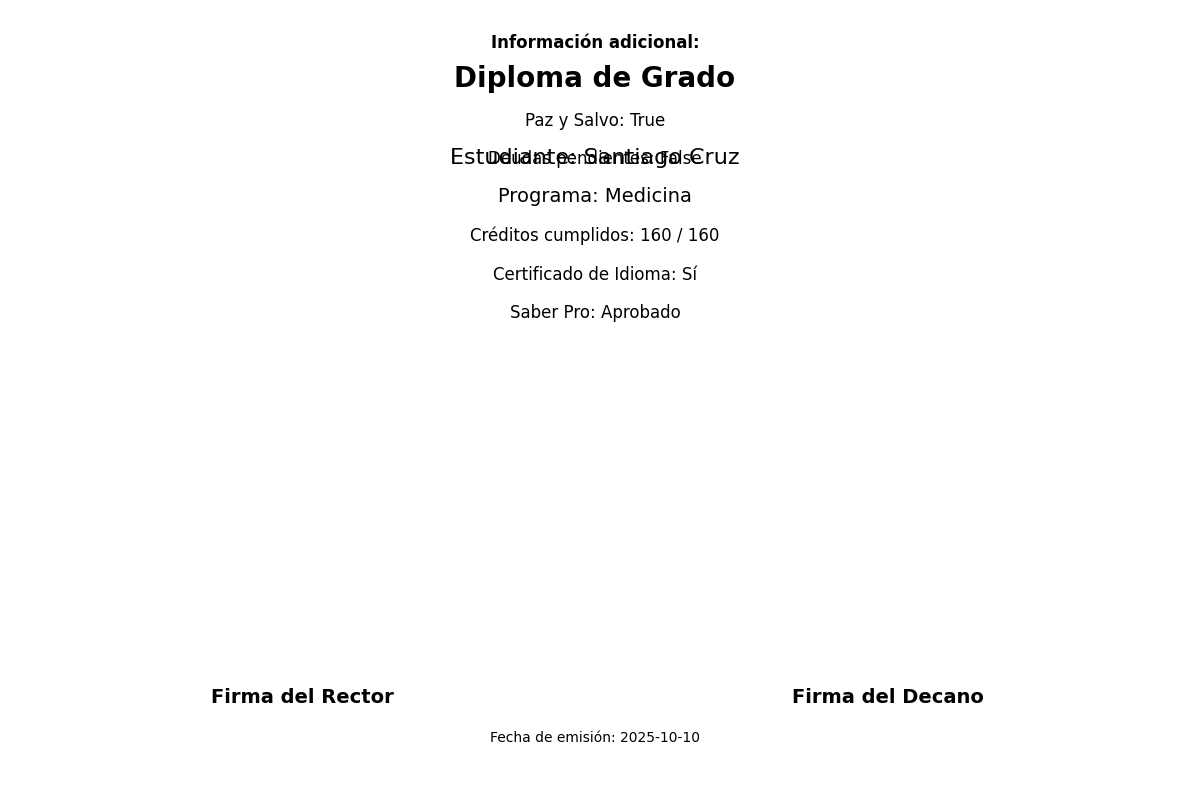

In [40]:
# Creación diploma
def crear_diploma(diploma):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Título del diploma
    ax.text(0.5, 0.9, "Diploma de Grado", fontsize=20, ha='center', fontweight='bold')

    # Nombre del Estudiante
    ax.text(0.5, 0.8, f"Estudiante: {diploma['estudiante']}", fontsize=16, ha='center')

    # Programa o carrera
    ax.text(0.5, 0.75, f"Programa: {diploma['programa']}", fontsize=14, ha='center')

    # Información de créditos
    ax.text(0.5, 0.7, f"Créditos cumplidos: {diploma['atributos']['creditos_cumplidos']} / {diploma['atributos']['creditos_totales']}", fontsize=12, ha='center')

    # Información del certificado de idioma
    certificado_idioma = "Sí" if diploma["atributos"]["certificado_idioma"] else "No"
    ax.text(0.5, 0.65, f"Certificado de Idioma: {certificado_idioma}", fontsize=12, ha='center')

    # Información sobre el Saber Pro
    saber_pro = "Aprobado" if diploma["atributos"]["saber_pro"] else "No Aprobado"
    ax.text(0.5, 0.6, f"Saber Pro: {saber_pro}", fontsize=12, ha='center')

    # Firma (simulada, puedes agregar más detalles)
    ax.text(0.25, 0.1, "Firma del Rector", fontsize=14, ha='center', fontweight='bold')
    ax.text(0.75, 0.1, "Firma del Decano", fontsize=14, ha='center', fontweight='bold')

    # Fecha de emisión
    fecha_emision = "Fecha de emisión: 2025-10-10"  # Se puede personalizar con la fecha real
    ax.text(0.5, 0.05, fecha_emision, fontsize=10, ha='center')

    # Información adicional fuera del diploma (pero visible)
    ax.text(0.5, 0.95, "Información adicional:", fontsize=12, ha='center', fontweight='bold')
    ax.text(0.5, 0.85, f"Paz y Salvo: {diploma['atributos']['paz_y_salvo']}", fontsize=12, ha='center')
    ax.text(0.5, 0.8, f"Deudas pendientes: {diploma['atributos']['deudas']}", fontsize=12, ha='center')

    # Diseño del borde del diploma
    box = FancyBboxPatch((0, 0), 1, 1, boxstyle="round,pad=0.05", linewidth=3, edgecolor="black", facecolor="none")
    ax.add_patch(box)

    # Configurar el gráfico
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")

    # Mostrar el "diploma"
    plt.tight_layout()
    plt.show()

# Crear el diploma visual
crear_diploma(diploma)